# Main Project Code

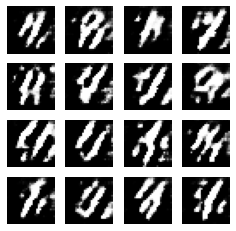

In [3]:
# Import the necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
from IPython import display
from tensorflow.keras import losses

# Load MNIST data and preprocess it
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype("float32")
x_train = (x_train - 127.5) / 127.5

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Define the generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh"))
    return model

# Define the discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=[28, 28, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model

generator = make_generator_model()
discriminator = make_discriminator_model()

# Custom loss function
def custom_loss(e, real_output, fake_output):
    real_loss = e * losses.BinaryCrossentropy()(tf.ones_like(real_output), real_output)
    fake_loss = (1 - e) * losses.BinaryCrossentropy()(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Define the optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training parameters
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Define the training step
@tf.function
def train_step(images, e, custom_loss=custom_loss):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = custom_loss(e, real_output, fake_output)
        disc_loss = custom_loss(1 - e, fake_output, real_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Train the GAN
def train(dataset, epochs, e):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch, e)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

# Generate and save images
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap="gray")
        plt.axis("off")

    plt.savefig("image_at_epoch_{:04d}.png".format(epoch))
    plt.show()

# Train the model
e = 0.5  # Change this value to modify the custom cost function
train(train_dataset, EPOCHS, e)


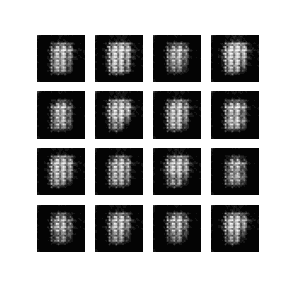

In [5]:
from PIL import Image
import re

# Generate and save the gif
anim_file = "dcgan_mnist_0.4.gif"

filenames = [filename for filename in os.listdir() if re.match(r"image_at_epoch_\d{4}\.png", filename)]
filenames = sorted(filenames, key=lambda x: int(x.split("_")[-1].split(".")[0]))

# Create a list of PIL.Image objects
images = [Image.open(filename) for filename in filenames]

# Save the images as an animated gif
images[0].save(anim_file, save_all=True, append_images=images[1:], duration=100, loop=0)

# Display the gif using IPython
from IPython.display import Image as IPythonImage
IPythonImage(filename=anim_file)


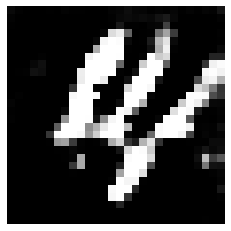

In [6]:
def generate_image(generator, noise_dim):
    noise = tf.random.normal([1, noise_dim])
    generated_image = generator(noise, training=False)
    generated_image = (generated_image + 1) / 2.0  # Rescale the pixel values to [0, 1] range
    generated_image = np.squeeze(generated_image)  # Remove the channel dimension
    return generated_image

# Generate a sample image using the generator model
generated_image = generate_image(generator, noise_dim)

# Plot the generated image
plt.imshow(generated_image, cmap="gray")
plt.axis("off")
plt.show()

In [10]:
@tf.function
def train_step(images, e, custom_loss=custom_loss):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = custom_loss(e, real_output, fake_output)
        disc_loss = custom_loss(1 - e, fake_output, real_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return disc_loss + gen_loss

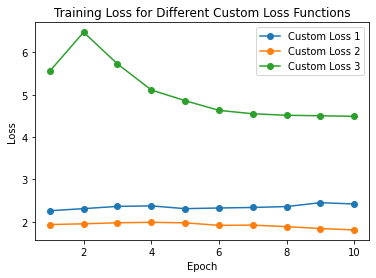

In [11]:
def custom_loss_1(e, real_output, fake_output):
    real_loss = e * losses.BinaryCrossentropy()(tf.ones_like(real_output), real_output) + \
                (1 - e) * losses.MeanSquaredError()(tf.ones_like(real_output), real_output)
    fake_loss = e * losses.BinaryCrossentropy()(tf.zeros_like(fake_output), fake_output) + \
                (1 - e) * losses.MeanSquaredError()(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def custom_loss_2(e, real_output, fake_output):
    const_factor = 0.1
    real_loss = e * (losses.BinaryCrossentropy()(tf.ones_like(real_output), real_output) + const_factor)
    fake_loss = (1 - e) * (losses.BinaryCrossentropy()(tf.zeros_like(fake_output), fake_output) + const_factor)
    total_loss = real_loss + fake_loss
    return total_loss

def custom_loss_3(e, real_output, fake_output):
    real_loss = e * tf.math.exp(losses.BinaryCrossentropy()(tf.ones_like(real_output), real_output))
    fake_loss = (1 - e) * tf.math.exp(losses.BinaryCrossentropy()(tf.zeros_like(fake_output), fake_output))
    total_loss = real_loss + fake_loss
    return total_loss

# Train the GAN
def train_gan_with_custom_loss(custom_loss_function, dataset, epochs, e):
    losses = []
    for epoch in range(epochs):
        epoch_losses = []
        for image_batch in dataset:
            epoch_losses.append(train_step(image_batch, e, custom_loss_function))
        losses.append(np.mean(epoch_losses))
    return losses

# Train the models with different custom loss functions
EPOCHS = 10
losses_1 = train_gan_with_custom_loss(custom_loss_1, train_dataset, EPOCHS, e)
losses_2 = train_gan_with_custom_loss(custom_loss_2, train_dataset, EPOCHS, e)
losses_3 = train_gan_with_custom_loss(custom_loss_3, train_dataset, EPOCHS, e)

# Plot the training metrics
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

plt.plot(epochs, losses_1, label="Custom Loss 1", marker="o")
plt.plot(epochs, losses_2, label="Custom Loss 2", marker="o")
plt.plot(epochs, losses_3, label="Custom Loss 3", marker="o")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss for Different Custom Loss Functions")
plt.show()

## Probability Density Plot

In [12]:
def generate_samples(generator, noise_dim, num_samples):
    noise = tf.random.normal([num_samples, noise_dim])
    generated_samples = generator(noise, training=False)
    generated_samples = (generated_samples + 1) / 2.0  # Rescale the pixel values to [0, 1] range
    return generated_samples.numpy().reshape(num_samples, -1)

num_samples = 1000
generated_samples = generate_samples(generator, noise_dim, num_samples)

<ipython-input-14-b9f87c719bf8>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(generated_samples[:, pixel_index], shade=True)


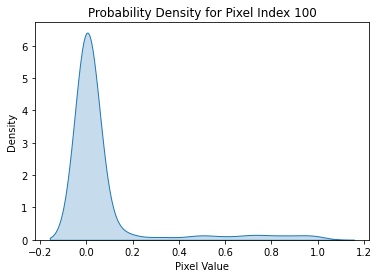

In [14]:
import seaborn as sns

# Choose a pixel index to plot the density (between 0 and 783)
pixel_index = 100

sns.kdeplot(generated_samples[:, pixel_index], shade=True)
plt.xlabel("Pixel Value")
plt.ylabel("Density")
plt.title(f"Probability Density for Pixel Index {pixel_index}")
plt.show()

## Statistical Visualization for GAN model

In [19]:
num_samples = 1000
generated_samples = generate_samples(generator, noise_dim, num_samples)

# Load the dataset and preprocess it
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32")
train_images = (train_images) / 255  # Normalize the images to [-1, 1]

# Batch and shuffle the data
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

real_batch = next(iter(train_dataset))
real_samples = real_batch.numpy().reshape(real_batch.shape[0], -1)

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Choose a pixel index to plot the statistics (between 0 and 783)
pixel_index = 100

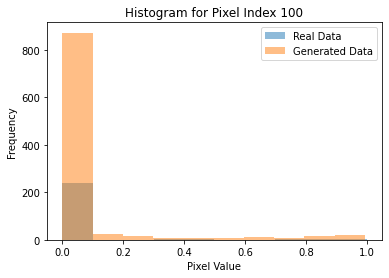

In [22]:
# Histogram
plt.hist(real_samples[:, pixel_index], alpha=0.5, label="Real Data")
plt.hist(generated_samples[:, pixel_index], alpha=0.5, label="Generated Data")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.title(f"Histogram for Pixel Index {pixel_index}")
plt.legend()
plt.show()

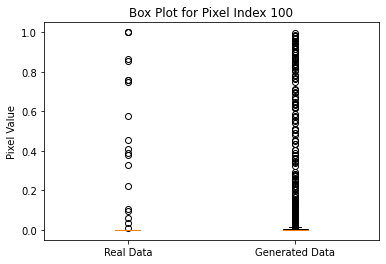

In [23]:
# Box Plot
plt.boxplot([real_samples[:, pixel_index], generated_samples[:, pixel_index]],
            labels=["Real Data", "Generated Data"])
plt.ylabel("Pixel Value")
plt.title(f"Box Plot for Pixel Index {pixel_index}")
plt.show()

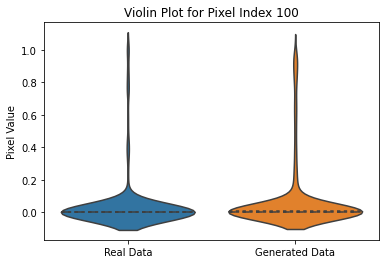

In [24]:
# Violin Plot
sns.violinplot(data=[real_samples[:, pixel_index], generated_samples[:, pixel_index]],
               scale="width", inner="quartile")
plt.xticks([0, 1], ["Real Data", "Generated Data"])
plt.ylabel("Pixel Value")
plt.title(f"Violin Plot for Pixel Index {pixel_index}")
plt.show()